In [1]:
import numpy as np

from robust_smc.data import TANSimulator, dem
from robust_smc.sampler import LinearGaussianBPF, RobustifiedLinearGaussianBPF

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
time = 200
time_step = 0.1
observation_std = 20.0

seed = 1992

num_samples = 1000

num_frequencies = 6

In [3]:
# process_std = np.array([1.   , 1.   , 3.   , 0.145, 0.228, 1.15 ]) * 1e-1
process_std = None
simulator = TANSimulator(time, time_step=time_step, observation_std=observation_std,
                         process_std=process_std, seed=seed)

In [4]:
transition_matrix = simulator.transition_matrix
transition_cov = np.diag(simulator.process_std ** 2)
observation_cov = simulator.observation_std ** 2

In [5]:
prior_std = np.array([1e-1, 1e-1, 1.0, 1e-2, 1e-2, 1e-1])
X_init = simulator.X0[None, :] + prior_std[None, :] * np.random.randn(num_samples, 6)
X_init = X_init.squeeze()

In [6]:
def piecewise_dem(X, Y, num_frequencies):
    levels = np.arange(-1000, 1001, 250)
    Z = dem(X, Y, num_frequencies=num_frequencies)
    idx = np.digitize(Z, levels)
    lookup = np.arange(-1250 , 1251, 250)
    ZZ = lookup[idx]
    return ZZ

In [7]:
def observation_model(X):
    return X[:, 2][:, None].copy() - piecewise_dem(X[:, 0][:, None].copy(), X[:, 1][:, None].copy(), num_frequencies)

In [8]:
xx = np.linspace(-10000, 13000, 5000)
yy = np.linspace(-10000, 6000, 5000)
X, Y = np.meshgrid(xx, yy)

In [9]:
def plot_terrain(state_sequence, title):
    plt.figure(figsize=(15, 6))
    Z = dem(X.flatten()[:, None], Y.flatten()[:, None], num_frequencies=6)
    Z = Z.reshape(5000, 5000)
    levels = np.arange(-1000, 1001, 250)
    plt.contourf(X, Y, Z, levels=levels)
    plt.colorbar()
    plt.scatter(simulator.X[1:, 0], simulator.X[1:, 1], c=np.arange(0, time, time_step),
                cmap='Blues', label='True Sequence')
    plt.colorbar()
    for i in range(100):
        plt.scatter(state_sequence[1:, i, 0], state_sequence[1:, i, 1], 
                    c=np.arange(0, time, time_step), cmap='Reds', label='Predicted')
    plt.colorbar()
    plt.title(title)

In [10]:
vanilla_bpf = LinearGaussianBPF(
    data=simulator.Y,
    transition_matrix=transition_matrix, 
    transition_cov=transition_cov, 
    X_init=X_init, 
    observation_model=observation_model,
    num_samples=num_samples,
    observation_cov=observation_cov
)
vanilla_bpf.sample()

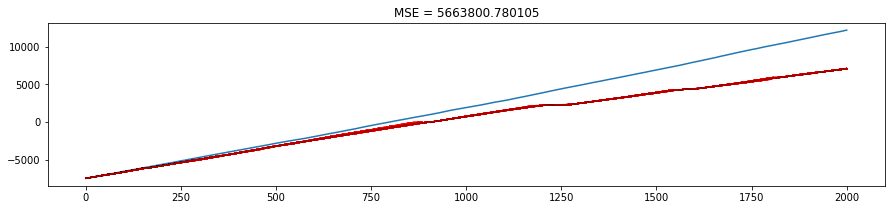

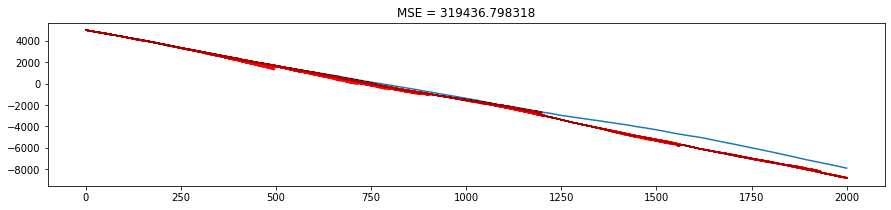

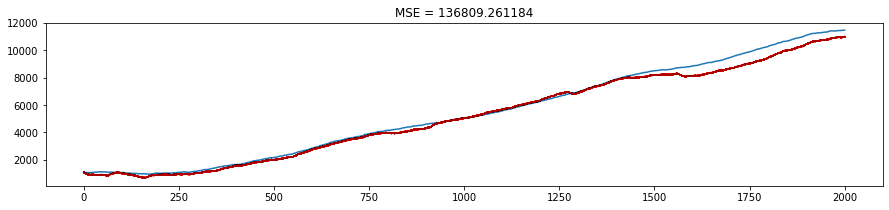

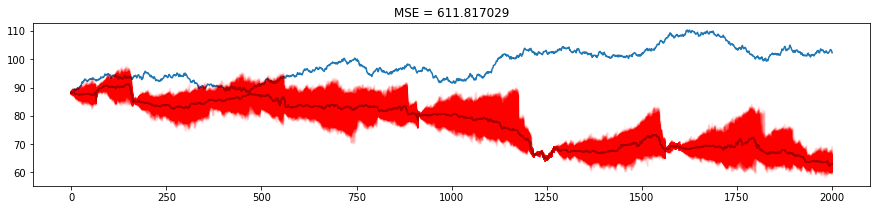

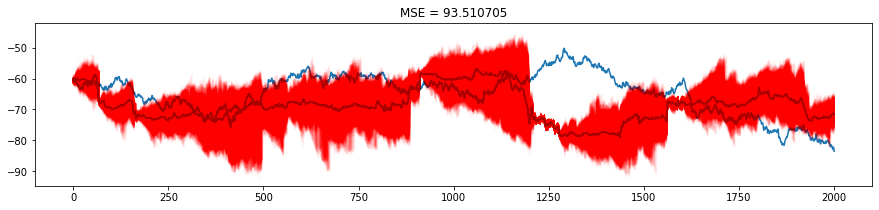

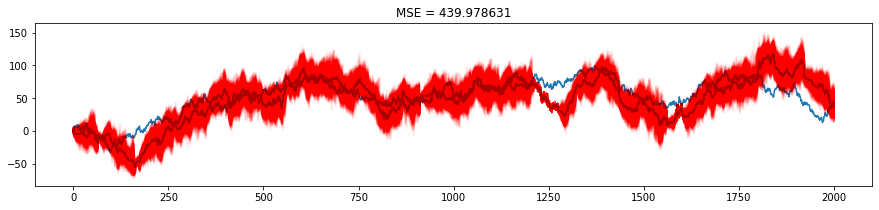

In [11]:
for var in range(6):
    plt.figure(figsize=(15, 3))
    traj = np.stack(vanilla_bpf.X_trajectories)
    plt.plot(simulator.X[:, var])
    mean = traj[:, :, var].mean(axis=1)
    plt.plot(mean, c='k', alpha=0.8, ls='-')
    mse = mean_squared_error(simulator.X[:, var], mean)
    for i in range(num_samples):
        plt.plot(traj[:, i, var], c='r', alpha=0.01, ls='-')
        lims = (np.min(traj[:, i, var]), np.max(traj[:, i, var]))
#         plt.ylim(lims[0] - 5., lims[1] + 5.0)
        plt.title('MSE = {:4f}'.format(mse))

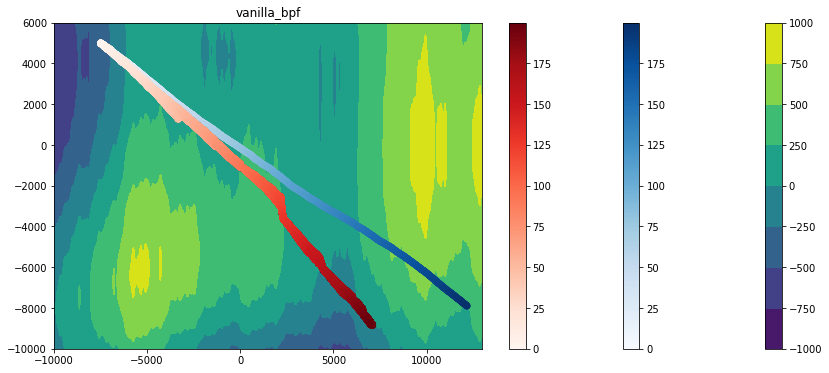

In [12]:
plot_terrain(traj, 'vanilla_bpf')

Text(0.5, 1.0, 'Effective sample size with time')

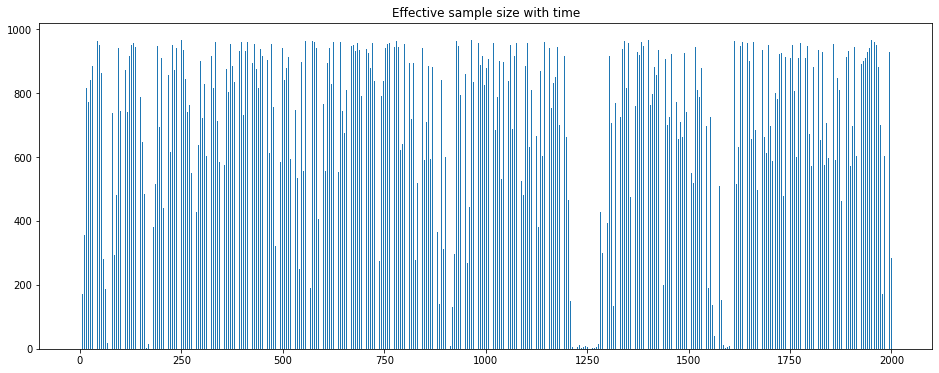

In [13]:
ess = [vanilla_bpf.effective_sample_size(logw) for logw in vanilla_bpf.logw]

plt.figure(figsize=(16, 6))
plt.bar(range(len(ess)), ess, width=0.4)
plt.title('Effective sample size with time')
# plt.ylim((600, 1000));

In [14]:
robust_bpf = RobustifiedLinearGaussianBPF(
    beta=0.1,
    data=simulator.Y,
    transition_matrix=transition_matrix, 
    transition_cov=transition_cov, 
    X_init=X_init, 
    observation_model=observation_model,
    num_samples=num_samples,
    observation_cov=observation_cov
)
robust_bpf.sample()

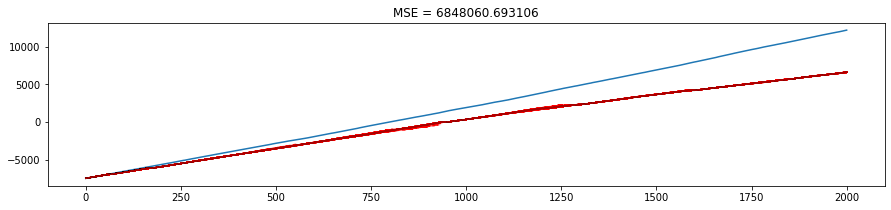

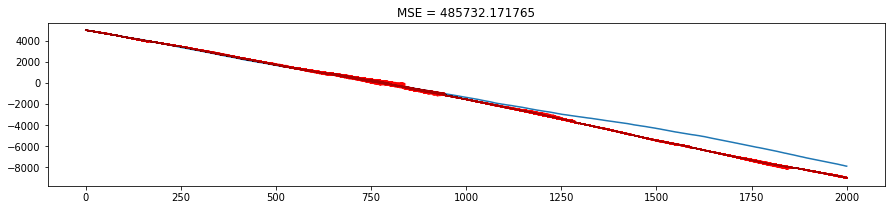

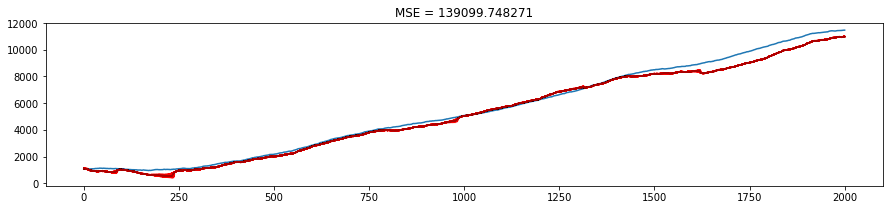

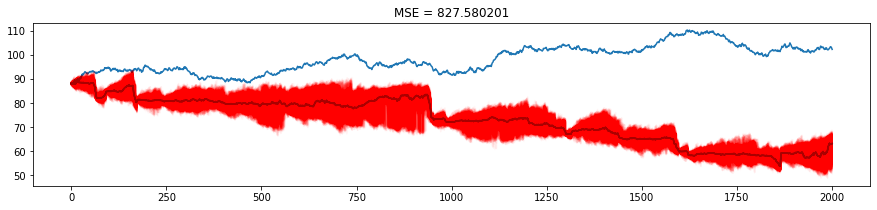

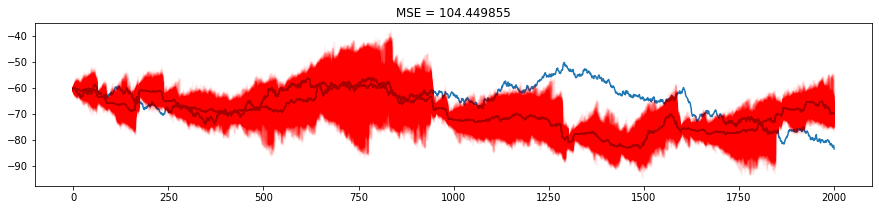

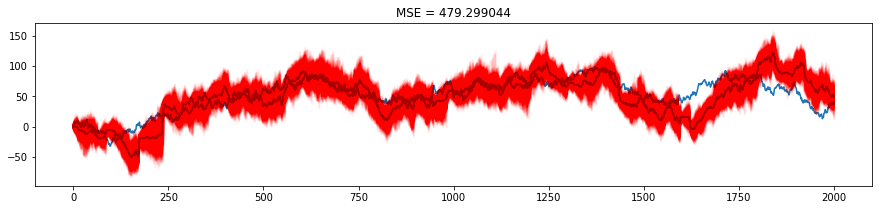

In [15]:
for var in range(6):
    plt.figure(figsize=(15, 3))
    traj = np.stack(robust_bpf.X_trajectories)
    plt.plot(simulator.X[:, var])
    mean = traj[:, :, var].mean(axis=1)
    plt.plot(mean, c='k', alpha=0.8, ls='-')
    mse = mean_squared_error(simulator.X[:, var], mean)
    for i in range(num_samples):
        plt.plot(traj[:, i, var], c='r', alpha=0.01, ls='-')
        lims = (np.min(traj[:, i, var]), np.max(traj[:, i, var]))
#         plt.ylim(lims[0] - 5., lims[1] + 5.0)
        plt.title('MSE = {:4f}'.format(mse))

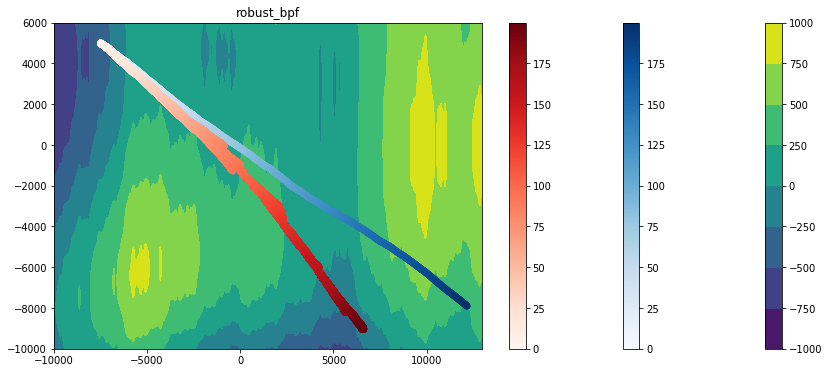

In [16]:
plot_terrain(traj, 'robust_bpf')

Text(0.5, 1.0, 'Effective sample size with time')

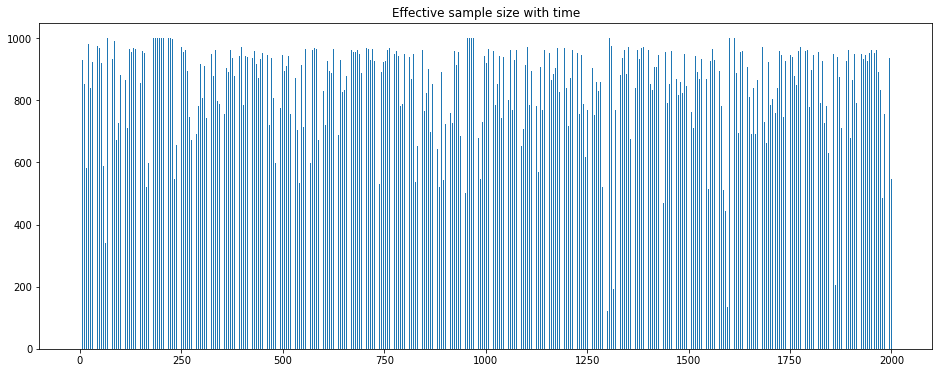

In [17]:
ess = [robust_bpf.effective_sample_size(logw) for logw in robust_bpf.logw]

plt.figure(figsize=(16, 6))
plt.bar(range(len(ess)), ess, width=0.4)
plt.title('Effective sample size with time')
# plt.ylim((600, 1000));

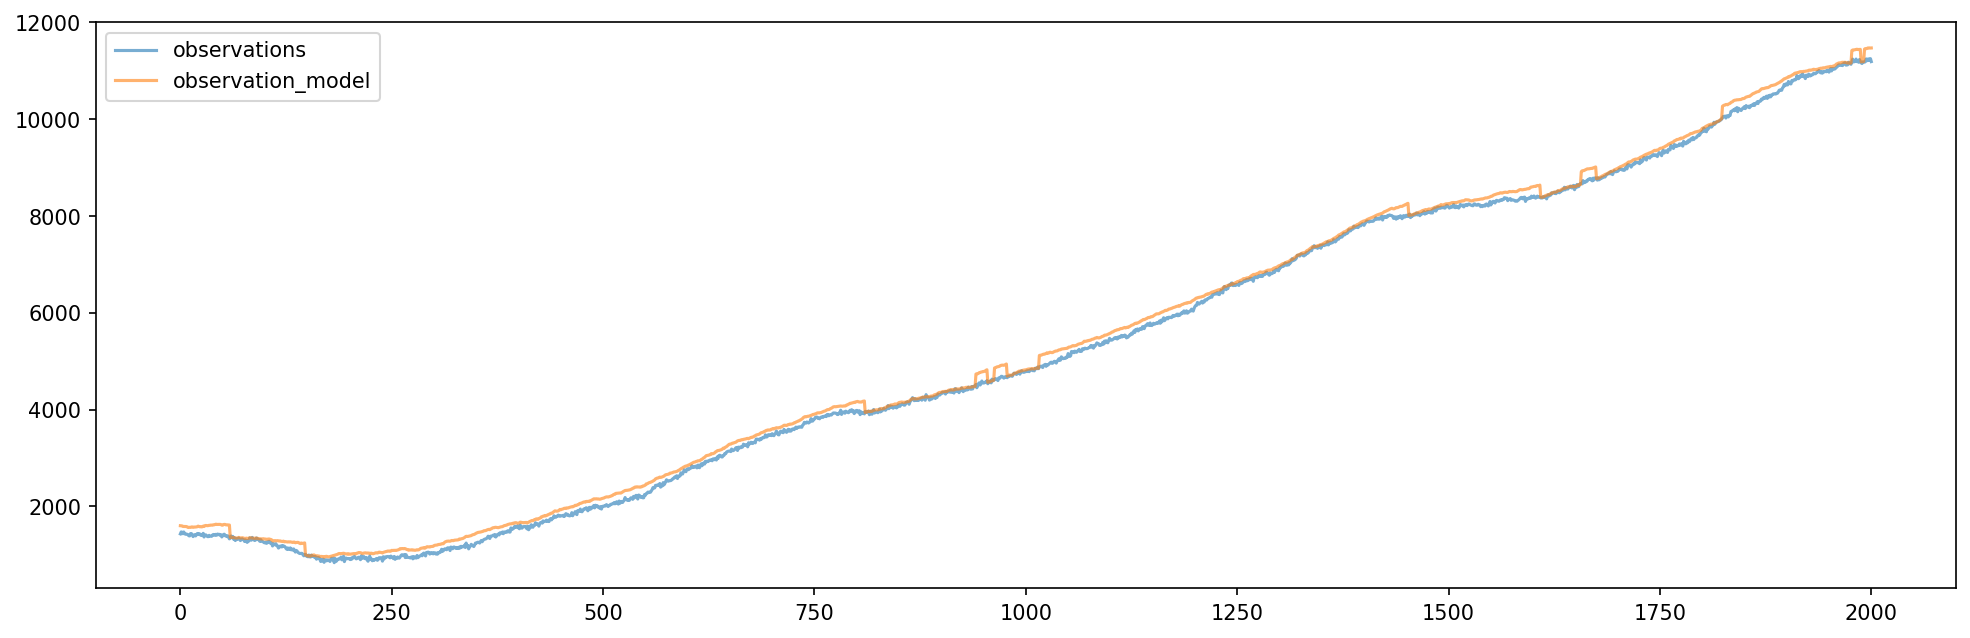

In [18]:
plt.figure(figsize=(16, 5), dpi=150)
plt.plot(simulator.Y, label='observations', alpha=0.6)
plt.plot(observation_model(simulator.X), label='observation_model', alpha=0.6)
plt.legend()